# PRMT-2297: Look at attachments data from a supplier perspective


## Context
We have performed some analysis on the attachments data set which suggests that nearly half of transfers contain no attachments. When we presented this in showcase we received feedback from clinical leads that they believe the number to be higher. It was suggested that one reason could be because some documents won't be included if, for example, they are EMIS and stored in Docman. 

## Scope
- Look at attachments data for 3 months
- Identify the proportion of transfers per supplier that contain attachments
- Identify the average no. attachments per transfer containing attachments, split by supplier 
- Look at attachments at a practice level for the following practices:
    - Clevedon Medical Centre - L81040
    - Paxton Green Group Practice - G85039
    - Vine Medical Centre - H81128

In [1]:
import pandas as pd
import numpy as np
import datetime

#### Load Attachment Data

In [ ]:
data_folder="s3://prm-gp2gp-data-sandbox-dev/PRMT-2297-supplier-attachments/"
# attachment_metadata_files = [
#     "4-2021-attachment-metadata.csv.gz",
#     "5-2021-attachment-metadata.csv.gz",
#     "6-2021-attachment-metadata.csv.gz"
# ]

attachment_metadata_files = [
    "attachments-with-domain-data-4-2021.csv.gz",
    "attachments-with-domain-data-5-2021.csv.gz",
    "attachments-with-domain-data-6-2021.csv.gz"
]

attachments = pd.concat([pd.read_csv(data_folder+file, parse_dates=["_time"], na_values=["Unknown"], dtype={"Length": pd.Int64Dtype()}) for file in attachment_metadata_files])

In [ ]:
attachments['DomainData'].value_counts()

None                     28516322
X-GP2GP-Skeleton: Yes       55438
Name: DomainData, dtype: int64

In [ ]:
non_core_attachments_bool=attachments['DomainData']!='X-GP2GP-Skeleton: Yes'
attachments_real=attachments.loc[non_core_attachments_bool]

In [ ]:
gp2gp_messages_files = [
    "4-2021-gp2gp-messages.csv.gz",
    "5-2021-gp2gp-messages.csv.gz",
    "6-2021-gp2gp-messages.csv.gz"
]
gp2gp_messages = pd.concat([pd.read_csv(data_folder+file, parse_dates=["_time"]) for file in gp2gp_messages_files])

## Deduplicate attachment data

In [ ]:
ehr_request_completed_messages = gp2gp_messages[gp2gp_messages["interactionID"] == "urn:nhs:names:services:gp2gp/RCMR_IN030000UK06"]

unique_ehr_request_completed_messages = ehr_request_completed_messages.sort_values(by="_time").drop_duplicates(subset=["conversationID"], keep="last")

In [ ]:
ehr_attachments = pd.merge(attachments_real, unique_ehr_request_completed_messages[["internalID", "interactionID"]], on="internalID", how="inner")

In [ ]:
conversation_attachment_counts=ehr_attachments.groupby('conversationID').agg({'attachmentID':'count', 'FromSystem': 'first', 'ToSystem': 'first'}).rename({'attachmentID':'Number of Attachments'},axis=1)

#### Load Transfers

In [ ]:
transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-sample-6/"
transfer_files = [
    "2021-4-transfers.parquet",
    "2021-5-transfers.parquet",
    "2021-6-transfers.parquet",
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))
# Generate ASID lookup that contains all the most recent entry for all ASIDs encountered
asid_file_location = "s3://prm-gp2gp-data-sandbox-dev/asid-lookup/asidLookup-Jun-2021.csv.gz"
asid_lookup = pd.read_csv(asid_file_location)
  
asid_lookup = asid_lookup.drop_duplicates().groupby("ASID").last().reset_index()
lookup = asid_lookup[["ASID", "MName", "NACS","OrgName"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'NACS': 'requesting_ods_code','OrgName':'requesting_practice_name'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'NACS': 'sending_ods_code','OrgName':'sending_practice_name'}, axis=1)

#### Merge Data

In [ ]:
full_transfers=transfers.merge(conversation_attachment_counts,left_on='conversation_id',right_index=True,how='left')
full_transfers['Contains Attachments']=full_transfers['Number of Attachments']>0
full_transfers.shape[0]

706250

In [ ]:
full_transfers['Contains Attachments'].value_counts(dropna=False)

True     358333
False    347917
Name: Contains Attachments, dtype: int64

## What percentage of transfers contain attachments for each supplier Pathway?

In [ ]:
supplier_table=full_transfers.groupby(['sending_supplier','requesting_supplier']).agg({'Contains Attachments':'mean','Number of Attachments':'mean'})
supplier_table=supplier_table.rename({'Contains Attachments':'% with Attachments','Number of Attachments':'Av attachments for transfers with attachments'},axis=1)
supplier_table['% with Attachments']=supplier_table['% with Attachments'].multiply(100)
supplier_table.fillna(0).round(1)

% with Attachments  \
sending_supplier requesting_supplier                       
EMIS             EMIS                               45.5   
                 SystmOne                           46.8   
                 Vision                              3.3   
SystmOne         EMIS                               80.9   
                 SystmOne                            0.0   
                 Vision                             13.3   
Vision           EMIS                                5.6   
                 SystmOne                            7.0   
                 Vision                              0.0   

                                      Av attachments for transfers with attachments  
sending_supplier requesting_supplier                                                 
EMIS             EMIS                                                          73.9  
                 SystmOne                                                      65.9  
                 Vision                                                        61.9  
SystmOne         EMIS                                                          49.4  
                 SystmOne                                                       0.0  
                 Vision                                                        49.0  
Vision           EMIS                                                          27.4  
                 SystmOne                                                      27.7  
                 Vision                                                         0.0

## What % of transfers contain attachments for the practices in question?

In [ ]:
practices={'Clevedon Medical Centre':'L81040','Paxton Green Group Practice':'G85039','Vine Medical Centre':'H81128'}
practice_counts=full_transfers.groupby(['sending_ods_code','sending_practice_name','sending_supplier','requesting_supplier']).agg({'Contains Attachments':['sum','mean'],'Number of Attachments':'mean'})
practice_counts.columns=['Number of Transfers','% of Transfers with Attachments','Av. Attachments for attachment transfers']
#practice_counts=practice_counts.loc[practices.values()]
practice_counts['% of Transfers with Attachments']=practice_counts['% of Transfers with Attachments'].multiply(100)
practice_counts.loc[practices.values()].fillna(0).round(1)

Number of Transfers  \
sending_ods_code sending_practice_name       sending_supplier requesting_supplier                        
L81040           CLEVEDON MEDICAL CENTRE     EMIS             EMIS                                  81   
                                                              SystmOne                              10   
                                                              Vision                                 0   
G85039           PAXTON GREEN GROUP PRACTICE EMIS             EMIS                                  96   
                                                              SystmOne                              21   
                                                              Vision                                 0   
H81128           VINE MEDICAL CENTRE         EMIS             EMIS                                  24   
                                                              SystmOne                               6   
                                                              Vision                                 0   

                                                                                   % of Transfers with Attachments  \
sending_ods_code sending_practice_name       sending_supplier requesting_supplier                                    
L81040           CLEVEDON MEDICAL CENTRE     EMIS             EMIS                                            55.1   
                                                              SystmOne                                        43.5   
                                                              Vision                                           0.0   
G85039           PAXTON GREEN GROUP PRACTICE EMIS             EMIS                                            37.2   
                                                              SystmOne                                        29.2   
                                                              Vision                                           0.0   
H81128           VINE MEDICAL CENTRE         EMIS             EMIS                                            48.0   
                                                              SystmOne                                        35.3   
                                                              Vision                                           0.0   

                                                                                   Av. Attachments for attachment transfers  
sending_ods_code sending_practice_name       sending_supplier requesting_supplier                                            
L81040           CLEVEDON MEDICAL CENTRE     EMIS             EMIS                                                     83.0  
                                                              SystmOne                                                 63.3  
                                                              Vision                                                    0.0  
G85039           PAXTON GREEN GROUP PRACTICE EMIS             EMIS                                                     59.0  
                                                              SystmOne                                                 56.0  
                                                              Vision                                                    0.0  
H81128           VINE MEDICAL CENTRE         EMIS             EMIS                                                     54.7  
                                                              SystmOne                                                 58.0  
                                                              Vision                                                    0.0

## Is the use of Docman based on the individual practice?

Text(0, 0.5, 'Number of EMIS Practices')

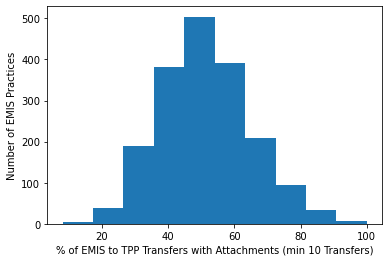

In [ ]:
practice_table=practice_counts.reset_index()
supplier_filter=(practice_table['sending_supplier']=='EMIS') & (practice_table['requesting_supplier']=='SystmOne')
count_filter=practice_table['Number of Transfers']>10
ax= practice_table.loc[supplier_filter & count_filter,'% of Transfers with Attachments'].plot.hist()
ax.set_xlabel("% of EMIS to TPP Transfers with Attachments (min 10 Transfers)")
ax.set_ylabel("Number of EMIS Practices")

Text(0, 0.5, 'Number of TPP Practices')

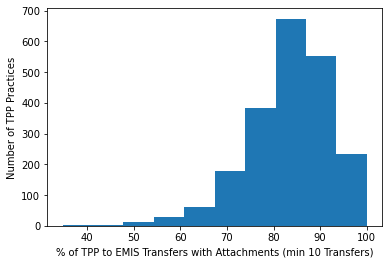

In [ ]:
practice_table=practice_counts.reset_index()
supplier_filter=(practice_table['sending_supplier']=='SystmOne') & (practice_table['requesting_supplier']=='EMIS')
count_filter=practice_table['Number of Transfers']>10
ax=practice_table.loc[supplier_filter & count_filter,'% of Transfers with Attachments'].plot.hist()
ax.set_xlabel("% of TPP to EMIS Transfers with Attachments (min 10 Transfers)")
ax.set_ylabel("Number of TPP Practices")

### Is there a difference in the types of attachments by supplier?

In [22]:
attachmentType_table=attachments_real.pivot_table(index='FromSystem',columns='attachmentType',aggfunc='count',values='conversationID')
attachmentType_table.div(attachmentType_table.sum(axis=1),axis=0).multiply(100)

attachmentType,cid,mid
FromSystem,,
EMIS Web,68.607298,31.392702
SystmOne,72.054064,27.945936
Vision 3,80.785406,19.214594


In [21]:
attachments_real['ContentType (high-level)']=attachments_real['ContentType'].apply(lambda x: x.split('/')[0] if type(x) is str else x)
ContentType_table=attachments_real.pivot_table(index='FromSystem',columns='ContentType (high-level)',aggfunc='count',values='conversationID')
ContentType_table.div(ContentType_table.sum(axis=1),axis=0).multiply(100)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


ContentType (high-level),NotProvided,application,audio,image,text
FromSystem,,,,,
EMIS Web,NaN,18.982652,0.000956,52.184794,28.831597
SystmOne,0.000876,23.196859,0.002526,63.168726,13.631013
Vision 3,NaN,31.649238,NaN,59.678336,8.672426


In [23]:
ContentType_table=attachments_real.pivot_table(index='FromSystem',columns='ContentType',aggfunc='count',values='conversationID')
ContentType_table.div(ContentType_table.sum(axis=1),axis=0).multiply(100)

ContentType,NotProvided,application/msword,application/octet-stream,application/pdf,application/xml,audio/basic,audio/mpeg,image/gif,image/jpeg,image/png,image/tiff,text/html,text/plain,text/rtf,text/xml
FromSystem,,,,,,,,,,,,,,,
EMIS Web,NaN,7.300382,1.788283,8.138307,1.755681,0.000111,0.000845,0.002961,1.306540,1.691274,49.184019,1.097884,5.140432,22.593282,NaN
SystmOne,0.000876,17.479603,2.490629,3.226626,NaN,0.002380,0.000146,0.001577,5.977323,12.919104,44.270722,2.908177,2.997260,7.401316,0.324260
Vision 3,NaN,26.989088,4.461241,0.198909,NaN,NaN,NaN,NaN,0.386451,0.511480,58.780405,3.966811,1.460559,2.994999,0.250057
